# DIABETES LEARNING



In [1]:
isGoogleColab = True

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15 or https://forums.fast.ai/t/am-i-doing-k-fold-cross-validation-right/84738/6  
- stratification in Kfold and Train_Test split for Multi Label problems is not straighforward. Check http://scikit.ml/index.html#. Use for now balanced datasets!!!!



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [ ]:
  #!kill -9 -1

## Keep Session Alive

Put this javascript code in the browser console

In [ ]:
# function ClickConnect(){
#    console.log("Working");
#    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
# }  setInterval(ClickConnect,300000)

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [ ]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 

# from packaging import version
# import IPython, ipykernel
# IPython.__version__
# if version.parse(IPython.__version__) <= version.parse("5.5.0"):
#     !pip install -q --upgrade ipython
#     !pip install -q --upgrade ipykernel
    
#     import os
#     import signal
#     os.kill(os.getpid(), signal.SIGTERM)
# print(f"ipykernel=={ipykernel.__version__}")
# print(f"IPython=={IPython.__version__}")

In [ ]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [2]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if isGoogleColab and torch.cuda.is_available():
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()
#     !nvidia-smi

GPU total Memory    : 11996954624
GPU free Memory     : 11455496192
GPU Memory used     : 541458432


## Mount the Google Drive to Google Colab

In [3]:
if isGoogleColab:
    from google.colab import drive
    import sys
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/MyDrive/Colab Notebooks/"
    sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/') #make src files importable

else:
    path_to_drive = "./"

Mounted at /content/drive


In [ ]:
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset_v2.rar" "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"
#!unrar x "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/augmentedDataset.rar" # extrai local
#!unzip "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/database.zip" -d "/content/drive/My Drive/Colab Notebooks/DiabetesLearning/"

## Install Deep Learning libraries

In [ ]:
# !pip install albumentations==1.1.0
# !pip install pytorch-lightning==1.4.8
# !pip install torchmetrics==0.6.2
# !pip install wandb==0.12.7
# !pip install fastai==2.5.3
# !pip install opencv-python-headless==4.1.2.30
# !pip install opencv-python==4.1.2.30

# ##restart runtime!!!

In [4]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)

Python: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
Pytorch: 1.10.0+cu111


# Data

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import torch
import torchvision
from PIL import Image
import timeit


In [41]:
pathBrazil = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/sprint0/'
pathBrazil_anno = pathBrazil + 'gt/'
pathBrazil_img = pathBrazil + 'done/'

pathUnimib = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/dataset_UNIMIB/' 
pathUnimib_anno = pathUnimib + 'gt/'
pathUnimib_img = pathUnimib + 'done/'

pathAicrowd = path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/' 
pathAicrowd_anno = pathAicrowd + 'gt/train/' #aicrowd validation data is also inside the train folder
pathAicrowd_img = pathAicrowd + 'done/train/'
# !rm "/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/train/done/075676.jpg"
# !cd "/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/done/train/" && ls | wc -l

In [42]:
np.random.seed(2) #mesma semente para todas as vezes que executar
randomSeed = 2

# fnamesBrazil = get_image_files(pathBrazil_img)
# print(fnamesBrazil[:3])

# fnamesUnimib = get_image_files(pathUnimib_img)
# print(fnamesUnimib[:-3])

fnamesAicrowd = get_image_files(pathAicrowd_img)
print(fnamesAicrowd[:-3])

fnames = fnamesAicrowd
path = pathAicrowd 
len(fnames)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54391

In [43]:
# Food detection or Multi Class Classification?
isFoodDetectionOnly = False

if isFoodDetectionOnly: 
  codes = ["Void","Food"]
  codesId = [0, 1]

else:
  codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')

  ### classesNumber Brazil dataset 
  # codesId = [code.split(": ")[0] for code in codes]
  # codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID

  ### classesNumber Unimib, Aicrowd, Food201 dataset
  codes = list(codes)
  codesId = list(range(0, len(codes)))


len(codes)

324

In [47]:
### fix GT ids: masks must be [0, 1, …, K-1] where K is the number of categories

def get_y_fn(item):
  "Grab a mask from a `filename` and adjust the pixels based on `adjustedGroundTruthIds`"
  if "original" in str(item) or "sprint" in str(item):
    itemGtPath = pathBrazil_anno + '/' + f'{item.stem}_GT.png'
  elif "UNIMIB" in str(item):
    itemGtPath = pathUnimib_anno + '/' + f'{item.stem}GT.png'
  elif "aiCrowd" in str(item):
    itemGtPath = pathAicrowd_anno + '/' + f'{item.stem}GT.png'

  # msk = PILMask.create(itemGtPath)
  msk = Image.open(itemGtPath)
  
  if not isFoodDetectionOnly and len(codes) < 255: # adjust ground truth ids only with is Multi Class Classification and only if there are less than 255 classes
    msk = np.array(msk)
    for i, val in enumerate(adjustedGroundTruthIds):
      msk[msk==adjustedGroundTruthIds[i]] = val
    msk = PILMask.create(msk)

  return msk

adjustedGroundTruthIds = dict()
adjustedGroundTruthIds = {i : int(codesId[i]) for i in range(len(codes))}

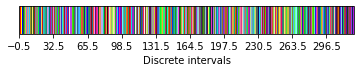

In [48]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
if not isFoodDetectionOnly:
  cmaplist[2] = "yellow" #arroz integral
  cmaplist[3] = "blue" #arroz branco
  cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

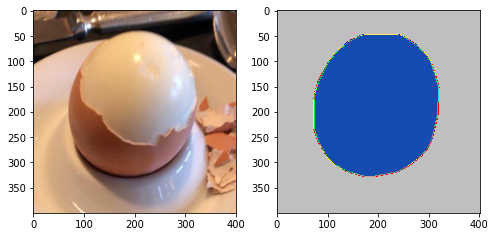

Ground truth Codes [ 0 20]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/done/train/139437.jpg


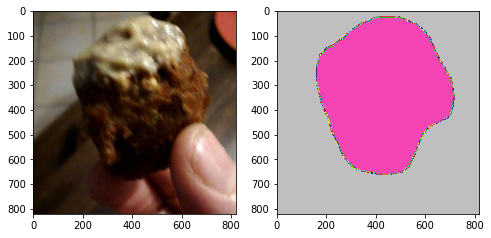

Ground truth Codes [  0 272]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/done/train/139351.jpg


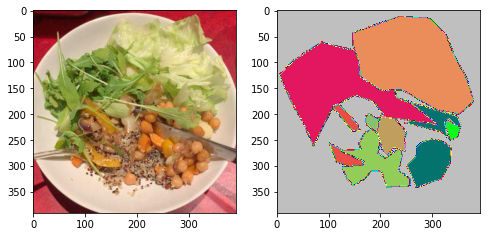

Ground truth Codes [  0  29  60  79 129 137 246 248 258]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/done/train/136062.jpg


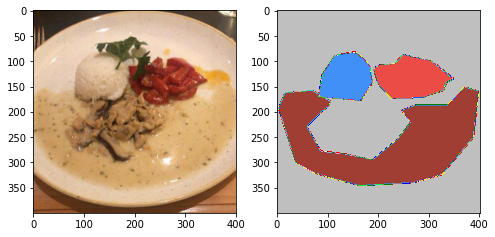

Ground truth Codes [ 0 32 57 60]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/done/train/139345.jpg


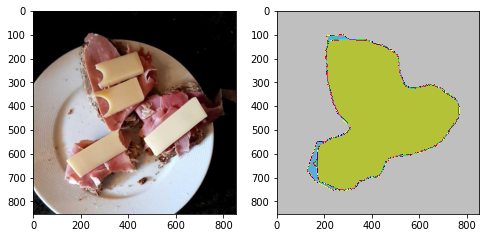

Ground truth Codes [  0   8  84 229]
/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/dataset_aiCrowd/done/train/008832.jpg


In [49]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

for idx in range(0,5):
  fig = plt.figure(figsize=(8,8))

  img = Image.open(fnames[idx])
  arr = np.asarray(img)
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(arr)

  img1 = get_y_fn(fnames[idx]) # use this when 'adjustedGroundTruthIds' is necessary
  # img1 = Image.open(get_y_fn(fnames[idx]))
  arr = np.asarray(img1)
  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(arr, cmap=cmap, norm=norm)
  plt.show()

  print("Ground truth Codes", np.unique(arr,return_counts=False))
  print(fnames[idx])


# MaskRCNN Utils

In [50]:
from torchvision import transforms as T
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import cv2

# resize all images before training! this is the default value for this whole notebook
imageSize = 256

def get_prediction(img_path, threshold, codes, model):
  img = Image.open(img_path)
  transform = T.Compose([T.Resize((imageSize,imageSize)), T.ToTensor()])
  img = transform(img).to(device)
  pred = model([img])

  pred_score = list(pred[0]['scores'].detach().cpu().numpy()) # the scores come sorted from the highest value

  # get all objects with score higher than threshold
  valid_preds = [pred_score.index(x) for x in pred_score if x>threshold]
  if len(valid_preds) == 0:
    return [],[],[],[]
  
  lastValidDetection = valid_preds[-1] + 1
  
  # take scores, masks, class names and boxes until the object with the lowest score (but all scores are higher than the threshold) 
  scores = pred_score[:lastValidDetection]

  masks = (pred[0]['masks']>0.5).detach().cpu().numpy()
  masks = [mask.squeeze() for mask in masks]
  masks = masks[:lastValidDetection]

  pred_class = [codes[i] for i in list(pred[0]['labels'].cpu().numpy())]
  classes = pred_class[:lastValidDetection]

  pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  boxes = pred_boxes[:lastValidDetection]
  
  return masks, boxes, classes, scores

def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def drawPrediction(img, masks, boxes, pred_cls, pred_scores, threshold=0.5, rect_th=1, text_size=0.5, text_th=2):
  fig = plt.figure(figsize=(20, 20))
  cols = 8
  rows = math.ceil(max(1, len(masks)/cols))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                   axes_pad=0.5,  # pad between axes in inch.
                  )
  
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img_clone = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    cv2.rectangle(img_clone, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    text = pred_cls[i] + ": " + "{:.2f}%".format(pred_scores[i] * 100)
    cv2.putText(img_clone, text, boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    grid[i].imshow(img_clone)

  # plt.figure(figsize=(4,4))
  # plt.imshow(img) #replace img_clone for img to get all predictions in just one image
  plt.show()

def instance_segmentation_api(img_path, codes, model, threshold=0.5):
  masks, boxes, pred_cls, pred_scores = get_prediction(img_path, threshold, codes, model)
  
  img = Image.open(img_path).convert("RGB")
  img = img.resize((imageSize,imageSize))
  img = np.asarray(img)
  drawPrediction(img, masks, boxes, pred_cls, pred_scores, threshold)


In [20]:
# util functions to concatenate masks when calculating acc_segmentation and miou

import functools

def concatMasks(mask1, mask2):
  bothNotZero = torch.logical_and(mask1, mask2)
  mask2[bothNotZero] = 0
  return mask1+mask2

def concatenateAndFlattenMasks(y_pred, y_true, threshold, pytorchDevice):
  flat_pred = torch.tensor([], device=pytorchDevice)
  flat_target = torch.tensor([], device=pytorchDevice)

  for pred, gt in zip(y_pred, y_true): #iterate every element in the batch and concatenate masks above certain threshold
    pred_masksWithLabel = []
    gt_masksWithLabel = []
    for pred_id, pred_mask, pred_score in zip(pred["labels"], pred["masks"], pred["scores"]):
      if pred_score > threshold:
        pred_mask = torch.round(pred_mask)
        pred_mask = torch.as_tensor(pred_mask, dtype=torch.uint8, device=pytorchDevice)
        pred_masksWithLabel.append(pred_mask*pred_id)
    for gt_id, gt_mask in zip(gt["labels"], gt["masks"]):
      gt_masksWithLabel.append(gt_mask*gt_id)
    
    if len(pred_masksWithLabel) == 0:
      concatenatedPreds = torch.zeros(gt_masksWithLabel[0].size(), device=pytorchDevice)
    else:
      concatenatedPreds = functools.reduce(concatMasks, pred_masksWithLabel)
    concatenatedGts = functools.reduce(concatMasks, gt_masksWithLabel)
    flat_pred = torch.cat((flat_pred, concatenatedPreds.flatten()), dim=0)
    flat_target = torch.cat((flat_target, concatenatedGts.flatten()), dim=0)

    # fig = plt.figure(figsize=(8,8))
    # ax1 = fig.add_subplot(1,2,1)
    # ax1.imshow(concatenatedPreds.squeeze().detach().numpy(), cmap=cmap, norm=norm)
    # ax1 = fig.add_subplot(1,2,2)
    # ax1.imshow(concatenatedGts.squeeze().detach().numpy(), cmap=cmap, norm=norm)
    # plt.show()

  return flat_pred.long(), flat_target.long()

# Pytorch Implementation

## Dataset

In [69]:
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as T

import torch

class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, foodDetectionOnly=False, transforms=None):
        self.fnames = fnames
        self.transforms = transforms
        self.foodDetectionOnly = foodDetectionOnly

    def __fixDegeneratedBoundingBox(self, xmin, ymin, xmax, ymax):
        print("Degenerated bounding box!!!!!!! Fixing error")
        if xmin == xmax and xmin == 0:
          xmax = 1
        elif xmin == xmax and xmin == imageSize - 1:
          xmin = imageSize - 2
        else:
          xmax += 1

        if ymin == ymax and ymin == 0:
          ymax = 1
        elif ymin == ymax and ymin == imageSize - 1:
          ymin = imageSize - 2
        else:
          ymax += 1
        
        return xmin, ymin, xmax, ymax

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx]).convert("RGB")
        img = np.asarray(img)
        mask = get_y_fn(self.fnames[idx]) 
        mask = np.asarray(mask)

        # data augmentation
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if (xmin == xmax) or (ymin == ymax):
              xmin, ymin, xmax, ymax = self.__fixDegeneratedBoundingBox(xmin, ymin, xmax, ymax)

            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        img = F.to_tensor(img)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        if self.foodDetectionOnly:
          # there is only one class for food detection
          labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
          labels = torch.as_tensor(obj_ids, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks


        ###### IGNORE THIS: it is necessary to be compatible with COCO dataset and torchvision engine
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        ######

        return img, target

    def __len__(self):
        return len(self.fnames)


In [70]:
# get data split from files or function

#### split train/test randomly ####
#from sklearn.model_selection import train_test_split
#X_train, X_test, _, _ = train_test_split(fnames, label_fnames, test_size=0.2, random_state=randomSeed, shuffle=True, stratify=None)

#### split by validation.txt (UNIMIB, AICROWD) ####
testFiles = np.loadtxt(path + 'validation.txt', dtype=str, delimiter='\n',encoding='utf')
X_test = [file for file in fnames if file.name in testFiles]
X_train = [file for file in fnames if file.name not in testFiles]

#### split by filenames array from pickle (BRAZIL DATASET) ####
# import pickle
# with open(path + "testFilenames.pkl", 'rb') as f:
#   testFiles = pickle.load(f)
# X_test = [file for file in fnames if file.name in testFiles]
# X_train = [file for file in fnames if file.name not in testFiles]

len(X_train), len(X_test)

(53445, 946)

## Data Augmentation

In [71]:
import albumentations as A
import cv2

def get_transforms(train: bool):
    transforms = []
    transforms.append(A.Resize(imageSize,imageSize)) 
    if train:
      transforms += [

                    ### SPATIAL
                    A.Flip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.ShiftScaleRotate(p=0.5, rotate_limit=25, border_mode=cv2.BORDER_REPLICATE),
                    A.OneOf([
                        A.ElasticTransform(p=1, border_mode=cv2.BORDER_REPLICATE),
                        A.GridDistortion(p=1, border_mode=cv2.BORDER_REPLICATE),
                    ], p=0.2),

                    # ### COLOR / NOISE
                    A.RGBShift(p=0.5, r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
                    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                    A.OneOf([
                      A.Blur(p=1),
                      A.GaussNoise(p=1),
                      A.CLAHE(p=1),
                    ], p=0.2),
                     
                    ]

    return A.Compose(transforms)

## Dataloaders

In [72]:
def collate_fn(batch):
    return tuple(zip(*batch))

bs = 4 # batch size

trainset = FoodDataset(X_train, foodDetectionOnly=isFoodDetectionOnly, transforms=get_transforms(train=True))
trainDataloader = torch.utils.data.DataLoader(
 trainset, batch_size=bs, shuffle=True, num_workers=4,
 collate_fn=collate_fn)

testset = FoodDataset(X_test, foodDetectionOnly=isFoodDetectionOnly, transforms=get_transforms(train=False))
testDataloader = torch.utils.data.DataLoader(
 testset, batch_size=bs, shuffle=False, num_workers=4,
 collate_fn=collate_fn)

len(trainset), len(testset)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(53445, 946)

## Visualize dataset

In [73]:
dataset2visualize = trainset

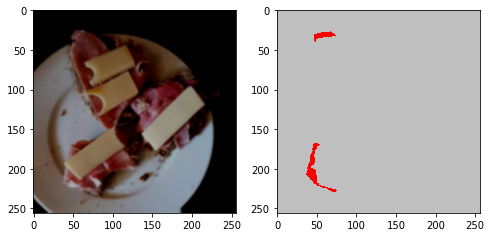

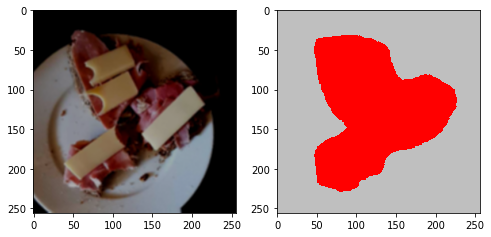

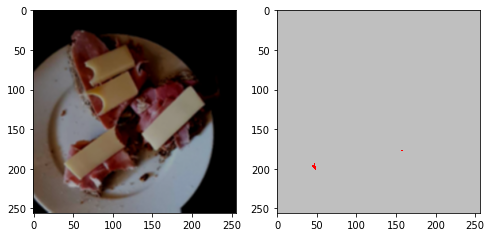

In [60]:
# show multiple masks from objects

idx = 4
img, label = dataset2visualize[idx]
img = img.permute(1,2,0).numpy() # tensor image has different dimensions. Permute when converting to numpy

for mask in label["masks"]:
  fig = plt.figure(figsize=(8,8))

  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(img)

  ax1 = fig.add_subplot(1,2,2)
  ax1.imshow(mask, cmap=cmap, norm=norm)
  plt.show()

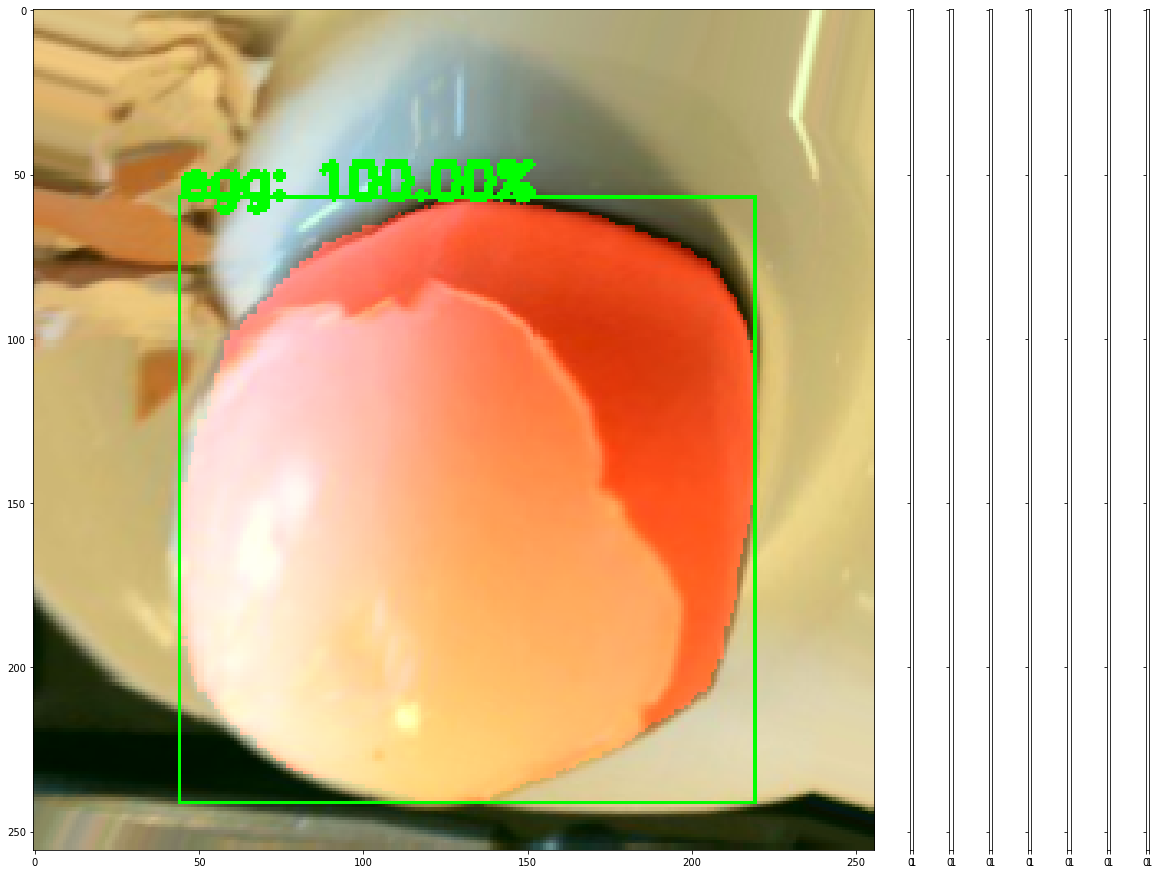

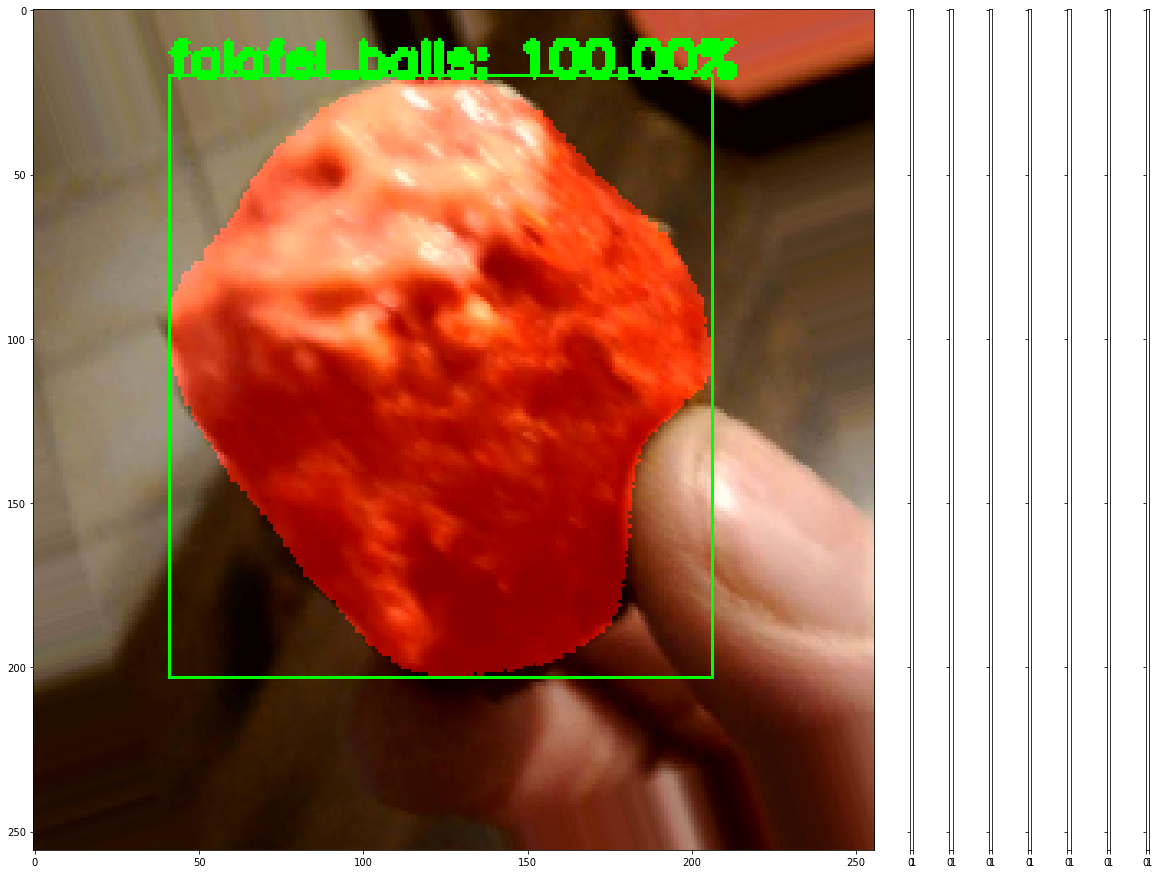

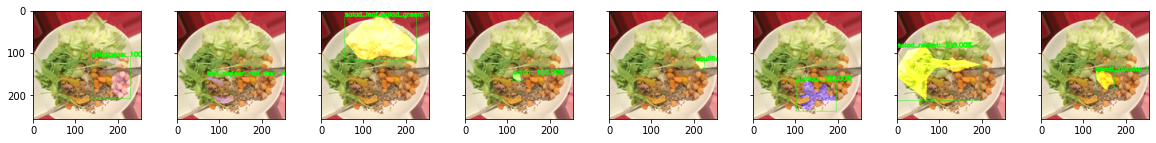

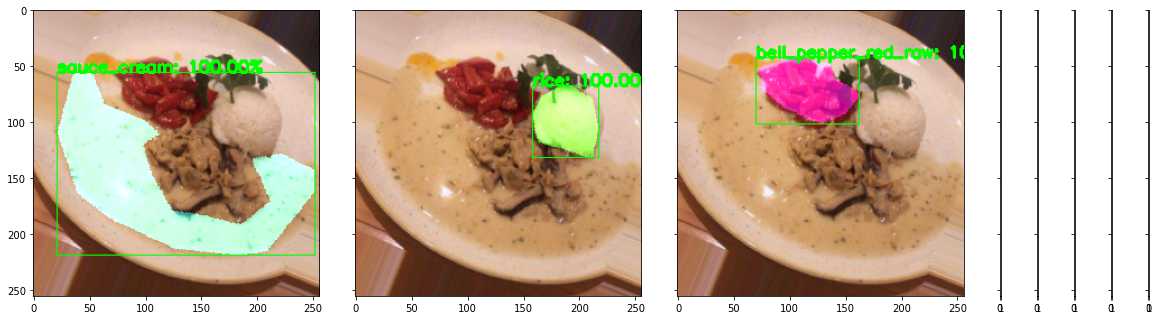

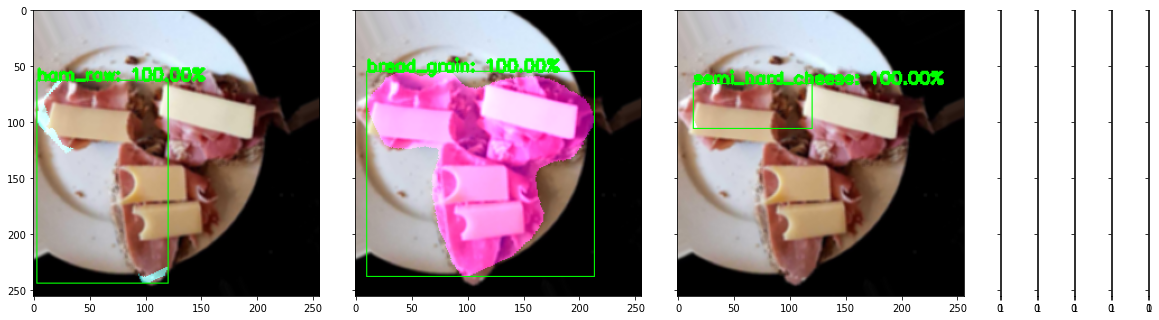

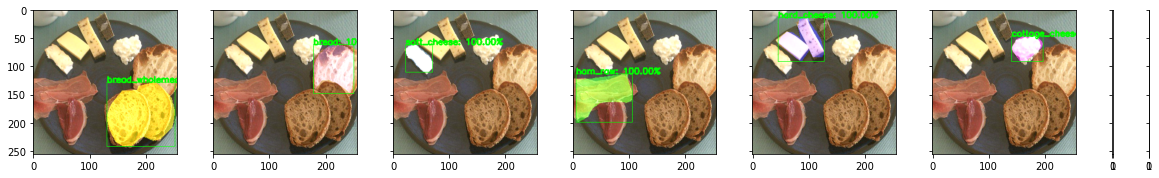

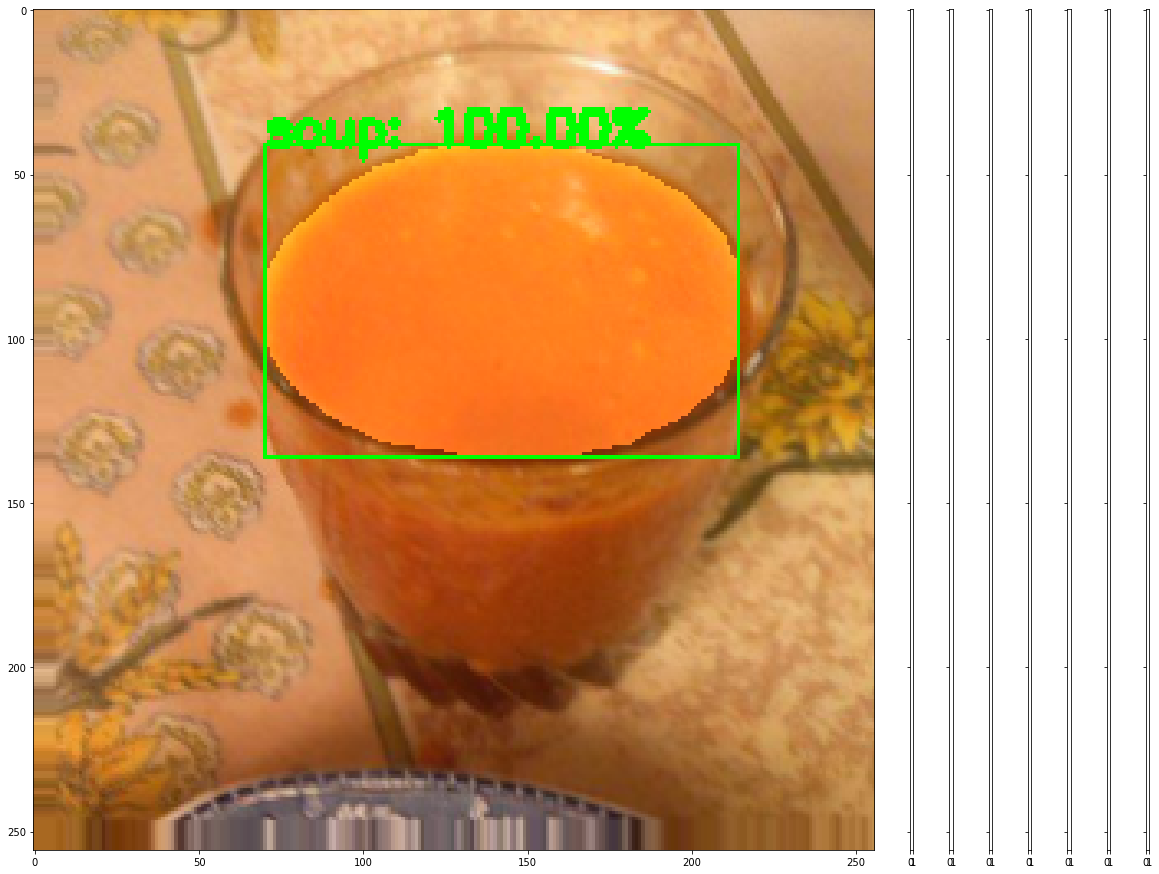

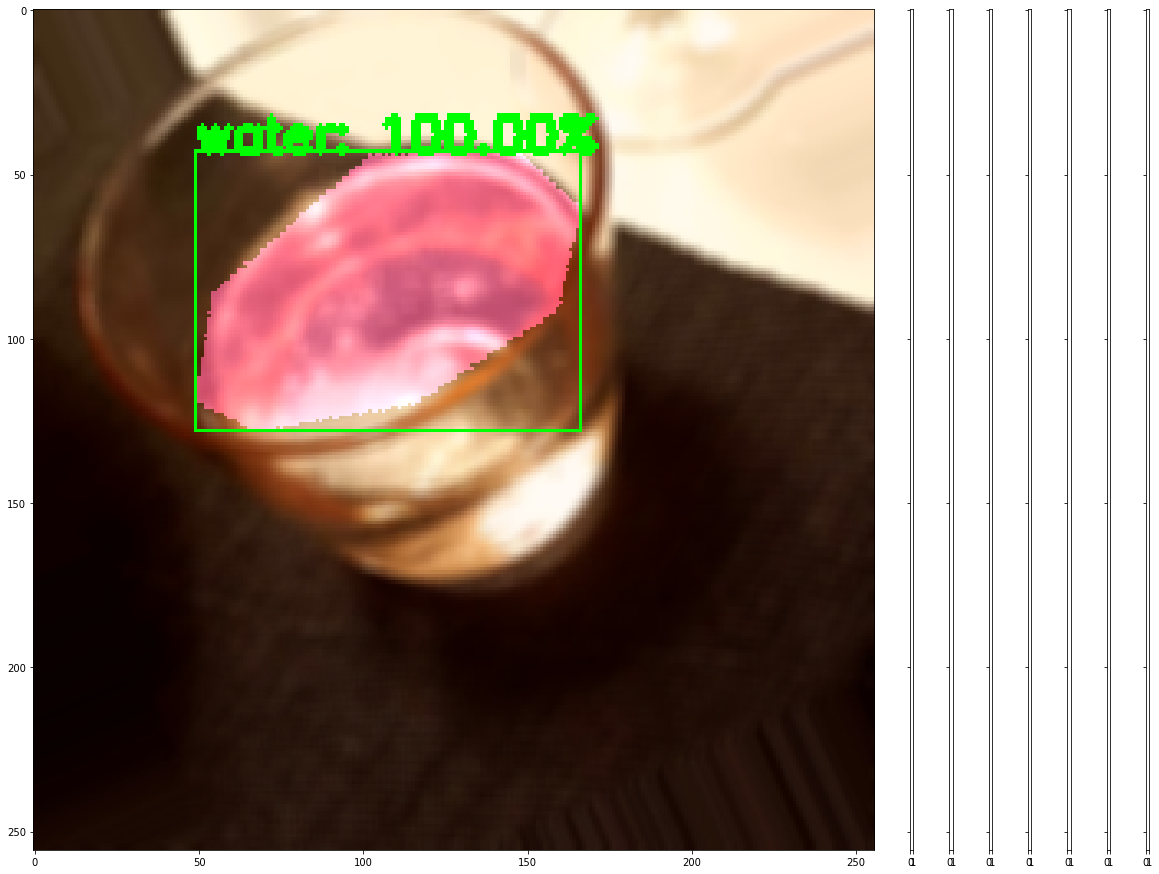

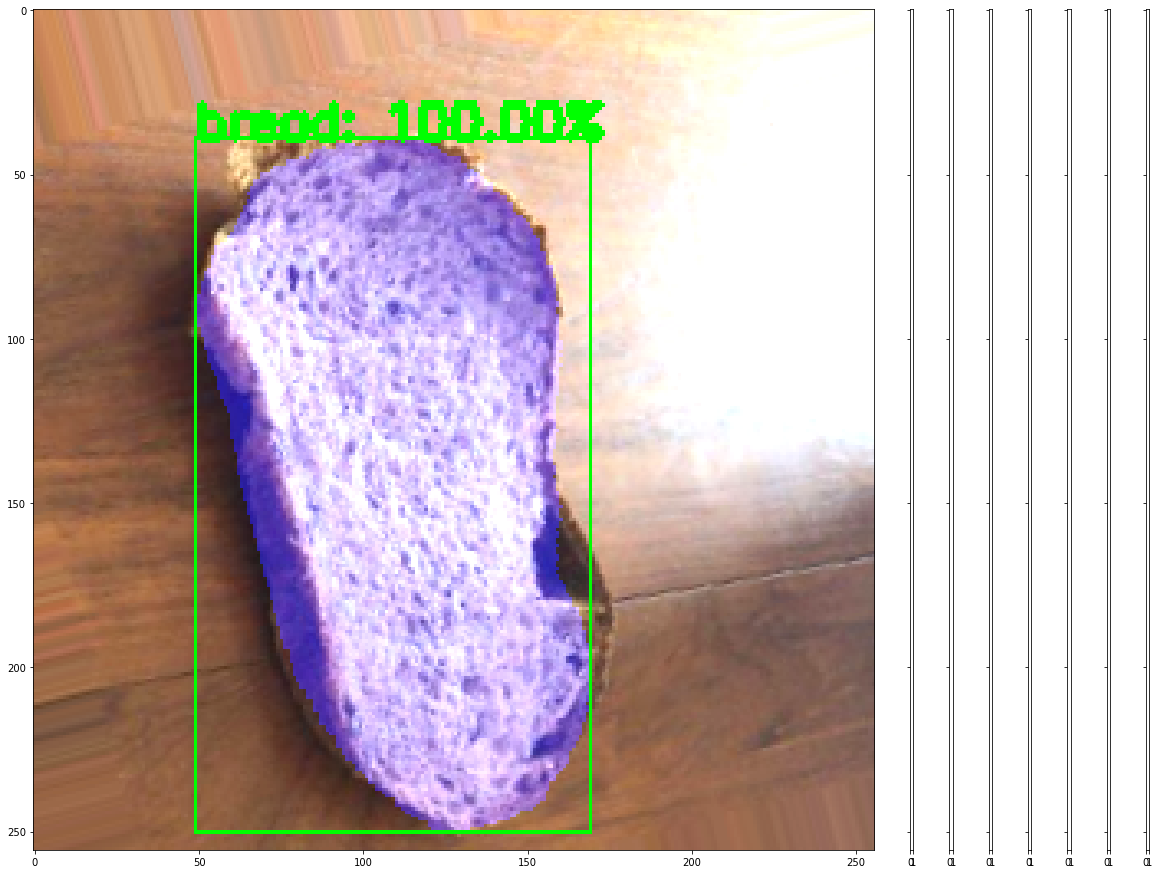

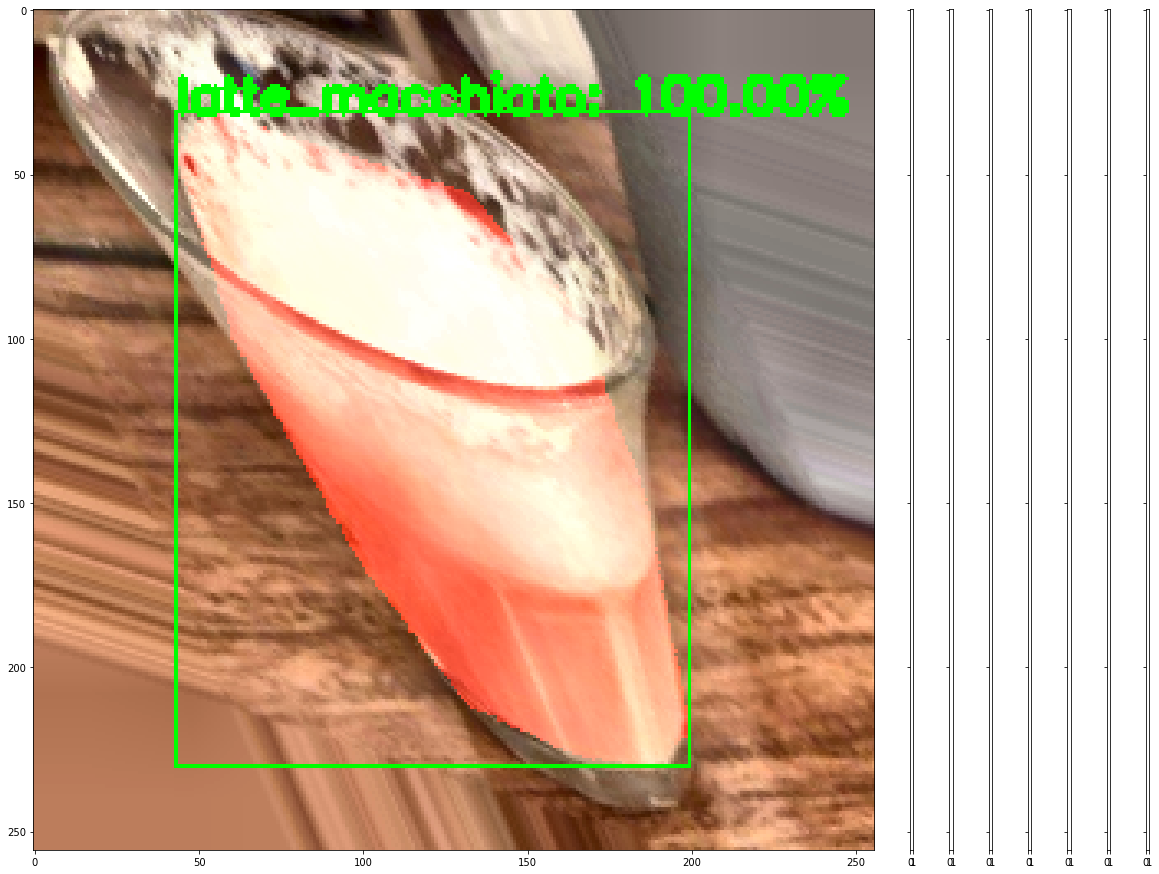

In [59]:
# show dataset examples with data augmentation

startIdx = 0

for idx in range(startIdx,startIdx + 10):
  img, label = dataset2visualize[idx]
  img = img.permute(1,2,0).numpy() # tensor image has different dimensions. Permute when converting to numpy
  img *= 255 # tensors are between 0 and 1. Rescale between 0 and 255
  img = img.astype(np.uint8) # convert tensor type to uint8


  masks = [mask.numpy() for mask in label["masks"]]
  boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(label['boxes'].detach().numpy())]
  labels = [codes[id] for id in (label["labels"])]
  scores = [1]*len(labels)

  drawPrediction(img, masks, boxes, labels,scores)

## Model

In [74]:
import torchvision
import copy
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
   
def get_model_instance_segmentation(num_classes, pretrainedModel=None):
    if pretrainedModel is None:
      print("Downloading default maskrcnn from pytorch")
      model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    else:
      print("Pretrained model detected")
      model = copy.deepcopy(pretrainedModel)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [75]:
#### freeze only backbone

def freezeBackboneLayer(model):
  for param in model.backbone.parameters():
    param.requires_grad=False

  for param in model.rpn.parameters():
    param.requires_grad=True
  for param in model.roi_heads.parameters():
    param.requires_grad=True

def unfreezeBackboneLayer(model):
  for param in model.backbone.parameters():
    param.requires_grad=True

  for param in model.rpn.parameters():
    param.requires_grad=True
  for param in model.roi_heads.parameters():
    param.requires_grad=True

In [ ]:
# test model inputs and outputs

# images,targets = next(iter(trainDataloader))
# # images = list(image for image in images)
# # targets = [{k: v for k, v in t.items()} for t in targets]

# model = get_model_instance_segmentation(len(codes))
# output = model(images,targets)   # Returns losses and detections
# print(output)

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions
# print(predictions[0])

## Use Pytorch Lightning to train

In [76]:
sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/torchvisionReferences/detection') #make src files importable
from torchvisionReferences.detection.engine import train_one_epoch, evaluate
import torch
from typing import List, Tuple
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import torchmetrics
import wandb
wandb.login()

class MaskRCNN(LightningModule):

    def __init__(self, num_classes=None, lr=None, weight_decay=None, epochs=None, freezeBackbone=True, pretrainedModel=None):
        super().__init__()

        self.modelMaskrcnn = get_model_instance_segmentation(num_classes=num_classes, pretrainedModel=pretrainedModel)
        self.modelMaskrcnn.transform.min_size = (imageSize,)
        self.modelMaskrcnn.transform.max_size = imageSize
        if freezeBackbone:
          self.freeze()

        # hparams
        self.max_epochs = epochs
        self.lr = lr if lr is not None else 0.01
        self.weight_decay = weight_decay if weight_decay is not None else 0.1

        # metrics
        self.predsThreshold = 0.8
        self.val_mAP = torchmetrics.MAP(class_metrics=False)
        self.test_mAP = torchmetrics.MAP(class_metrics=True)
        self.acc = torchmetrics.Accuracy(ignore_index=0)
        self.miou = torchmetrics.IoU(num_classes=num_classes, ignore_index=0, absent_score=1.0, reduction="elementwise_mean") # reduction = "none" or "elementwise_mean"

    def freeze(self):
      freezeBackboneLayer(self.modelMaskrcnn)
    
    def unfreeze(self):
      unfreezeBackboneLayer(self.modelMaskrcnn)

    def forward(self, input, target=None):
        if target is not None:
          return self.modelMaskrcnn(input, target) #train mode
        else: 
          return self.modelMaskrcnn(input) #eval mode
    
    def configure_optimizers(self):
        print("Configuring optimizer and setting sanity check to TRUE")
        self.validationSanityCheck = True
        params = [p for p in self.parameters() if p.requires_grad]
        optim = torch.optim.AdamW(params, lr=self.lr, weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=self.lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=self.max_epochs,
                                                 cycle_momentum=True)   

        return {
            "optimizer": optim,
            "lr_scheduler": lr_scheduler
        }

    
    def training_step(self, batch, batch_idx):
        x, y = batch
        loss_dict = self(x, y)
        loss = sum(loss for loss in loss_dict.values())
        
        metrics = {}
        metrics["loss"] = loss
        self.log_dict(metrics, on_step=True, on_epoch=True)

        return metrics

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        
        flat_pred, flat_target = concatenateAndFlattenMasks(preds, y, threshold=self.predsThreshold, pytorchDevice=self.device)
        self.acc.update(flat_pred, flat_target)
        self.miou.update(flat_pred, flat_target)         
        self.val_mAP.update(preds,y)


    def validation_epoch_end(self, outputs):
        # COCO evaluation
        if self.validationSanityCheck is False:
          results = evaluate(self.modelMaskrcnn, testDataloader, device=self.device)
        else:
          self.validationSanityCheck = False

        metricsAvg = {}

        metricsAvg = self.val_mAP.compute()
        self.val_mAP.reset()

        accuracy = self.acc.compute()
        metricsAvg["acc_segmentation"] = accuracy
        self.acc.reset()

        miouScore = self.miou.compute()
        metricsAvg["miou"] = miouScore
        self.miou.reset()

        print("Validation metrics")
        print("-----------------------------\n")
        [print(f"{metric}: {value}") for metric, value in metricsAvg.items()]
        print("\n-----------------------------")

        self.log_dict(metricsAvg, on_step=False, on_epoch=True, logger=True)
        return metricsAvg

    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        
        flat_pred, flat_target = concatenateAndFlattenMasks(preds, y, threshold=self.predsThreshold, pytorchDevice=self.device)
        self.acc.update(flat_pred, flat_target)
        self.miou.update(flat_pred, flat_target)
        self.test_mAP.update(preds, y)


    def test_epoch_end(self, outputs):
        metricsAvg = {}

        metricsAvg = self.test_mAP.compute()
        self.test_mAP.reset()

        accuracy = self.acc.compute()
        metricsAvg["acc_segmentation"] = accuracy
        self.acc.reset()

        miouScore = self.miou.compute()
        metricsAvg["miou"] = miouScore
        self.miou.reset()

        print("Test metrics")
        print("-----------------------------\n")
        [print(f"{metric}: {value}") for metric, value in metricsAvg.items()]
        print("\n-----------------------------")

        self.log_dict(metricsAvg, on_step=False, on_epoch=True, logger=True)
        return metricsAvg



wandb: Currently logged in as: bunoviske (use `wandb login --relogin` to force relogin)


In [77]:
# set hyperparameters
lr = 1e-3
wd = 5e-4
epochs = 20
grad_accumulation_batches = int(32/bs) # 32 is the final "batch size"

# load pretrained model from food detection task (use this only when you have Multi Class Classification)
# modelFoodDetection = None
# modelFoodDetection = MaskRCNN(num_classes=2, lr=lr, weight_decay=wd, epochs=epochs, freezeBackbone=True)
# modelFoodDetection.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/original/models/maskrcnn-FoodDetection-tccOriginal.pt"))

# instantiate pytorch lightning model
modelMaskrcnn = MaskRCNN(num_classes=len(codes), lr=lr, weight_decay=wd, epochs=epochs, freezeBackbone=True)

# load pretrained model if necessary
# modelMaskrcnn.load_state_dict(torch.load(path + "models/maskrcnnTorchLightningTraining-finetunning.pt"))

# delete food detection model
# del modelFoodDetection

In [78]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, QuantizationAwareTraining
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb_logger = WandbLogger(project="diabetesLearning-instanceSegmentation", log_model=False)
wandb_logger.watch(modelMaskrcnn, log='all', log_freq=100)

checkpoint_callback = ModelCheckpoint(monitor='map', mode="max", verbose=True)
# early_stop_callback = EarlyStopping(monitor='val_loss', mode="min", patience=50, verbose=True)
callbacks = [checkpoint_callback]

trainer = Trainer(gpus= 1 if torch.cuda.is_available() else 0,
            max_epochs=epochs, 
            accumulate_grad_batches=grad_accumulation_batches,
            # gradient_clip_val=1.0,
            # amp_backend='apex',
            # amp_level='02',
            precision=32,
            logger=wandb_logger,
            callbacks=callbacks
            )


wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# lr finder

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(modelMaskrcnn, train_dataloaders=trainDataloader, num_training=50)
lr = lr_finder.suggestion()
print("Suggested lr:",lr)

fig = lr_finder.plot(suggest=True)
fig.show()


In [ ]:
modelMaskrcnn.lr = 1e-3
wandb_logger.log_hyperparams({"lr": lr, "wd": wd, "epochs": epochs, "bs": bs})

### Training with frozen backbone

In [ ]:
# train last layers
modelMaskrcnn.freeze()
print("START TRAINING WITH FROZEN LAYERS")
trainer.fit(modelMaskrcnn, trainDataloader, testDataloader)

modelMaskrcnn = MaskRCNN.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)
torch.save(modelMaskrcnn.state_dict(), path + "models/temp-maskrcnn-noAugmentation.pt")
print(checkpoint_callback.best_model_path)

### Fine tunning

In [ ]:
# finetune everything

epochs = 20
modelMaskrcnn.unfreeze()
modelMaskrcnn.lr = modelMaskrcnn.lr/2
modelMaskrcnn.max_epochs = epochs

trainer = Trainer(gpus= 1 if torch.cuda.is_available() else 0,
            max_epochs=epochs, 
            accumulate_grad_batches=grad_accumulation_batches,
            # gradient_clip_val=1.0,
            # amp_backend='apex',
            # amp_level='02',
            precision=32,
            logger=wandb_logger,
            callbacks=callbacks
            )

print("START FINETUNNING")
trainer.fit(modelMaskrcnn, trainDataloader, testDataloader)

wandb.save(checkpoint_callback.best_model_path)

modelMaskrcnn = MaskRCNN.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)
torch.save(modelMaskrcnn.state_dict(), path + "models/maskrcnn-noAugmentation.pt")
print(checkpoint_callback.best_model_path)

In [ ]:
while True: pass

In [ ]:
# wandb_logger.close()
# wandb_logger.finalize("success")
# wandb.finish()

### Error Analysis

In [ ]:
# evaluate using torchmetrics

testTrainer = Trainer(gpus=1)
testTrainer.test(model=modelMaskrcnn, dataloaders=testDataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test metrics
-----------------------------

map: 0.595901608467102
map_50: 0.8260405659675598
map_75: 0.7151093482971191
map_small: 0.28829243779182434
map_medium: 0.6046537756919861
map_large: 0.5590543150901794
mar_1: 0.23930975794792175
mar_10: 0.6788721084594727
mar_100: 0.6794613003730774
mar_small: 0.4107142388820648
mar_medium: 0.6885791420936584
mar_large: 0.625
map_per_class: tensor([0.5959])
mar_100_per_class: tensor([0.6795])
acc_segmentation: 0.9300076365470886
miou: 0.9300076365470886

-----------------------------
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc_segmentation': 0.9300076365470886,
 'map': 0.595901608467102,
 'map_50': 0.8260405659675598,
 'map_75': 0.7151093482971191,
 'map_large': 0.5590543150901794,
 'map_medium': 0.6046537756919861,
 'map_per_class': 0.595901608467102,
 'map_small': 0.28829243779182434,
 'mar_1': 0.23930974304676056,
 'mar_10': 0.6788721084594727,
 'mar_100': 0.679461300373

[{'acc_segmentation': 0.9300076365470886,
  'map': 0.595901608467102,
  'map_50': 0.8260405659675598,
  'map_75': 0.7151093482971191,
  'map_large': 0.5590543150901794,
  'map_medium': 0.6046537756919861,
  'map_per_class': 0.595901608467102,
  'map_small': 0.28829243779182434,
  'mar_1': 0.23930974304676056,
  'mar_10': 0.6788721084594727,
  'mar_100': 0.6794613003730774,
  'mar_100_per_class': 0.6794613003730774,
  'mar_large': 0.625,
  'mar_medium': 0.6885791420936584,
  'mar_small': 0.4107142388820648,
  'miou': 0.9300076365470886}]

In [ ]:
# validate

start = 10
modelMaskrcnn.to(device)
modelMaskrcnn.eval()

for idx in range(start,start+20):
  instance_segmentation_api(str(X_test[idx]), codes, modelMaskrcnn, threshold=0.8)

In [ ]:
# evaluate using torchvision engine

# evaluate(modelMaskrcnn, testDataloader, device=device)

In [ ]:
# # evaluate with acc_segmentation

# def acc_segmentationMaskRCNN(y_pred, y_target, threshold=0.8): # y_pred and y_target are lists of dicts (batches)
#   flat_pred, flat_target = concatenateAndFlattenMasks(y_pred, y_target,threshold=threshold)
#   void_code = 0
#   mask = flat_target != void_code
#   return (flat_pred[mask]==flat_target[mask]).float().mean()

# from statistics import mean

# acc_total = []
# modelMaskrcnn.to(torch.device("cpu"))
# modelMaskrcnn.eval()
# for batch in testDataloader:
#   x, y = batch
#   preds = modelMaskrcnn(x)
#   acc_batch = acc_segmentationMaskRCNN(preds, y)
#   acc_total.append(acc_batch.item())

# print("Final acc_segmentation:", mean(acc_total))

### Predictions

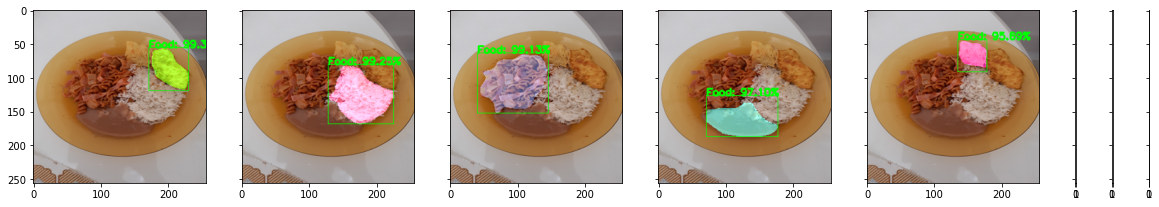

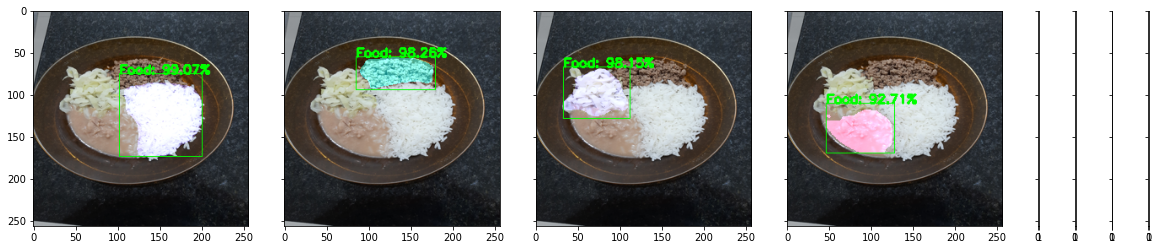

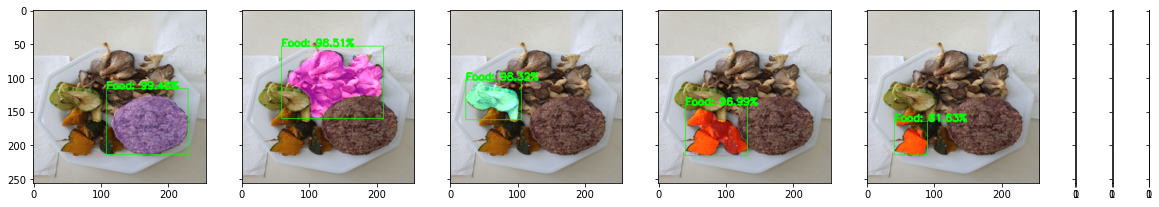

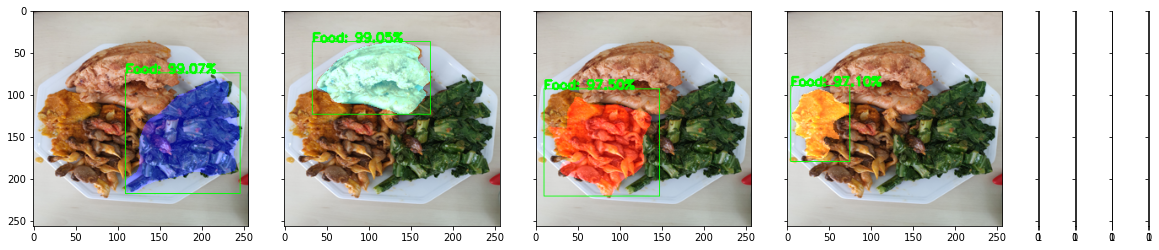

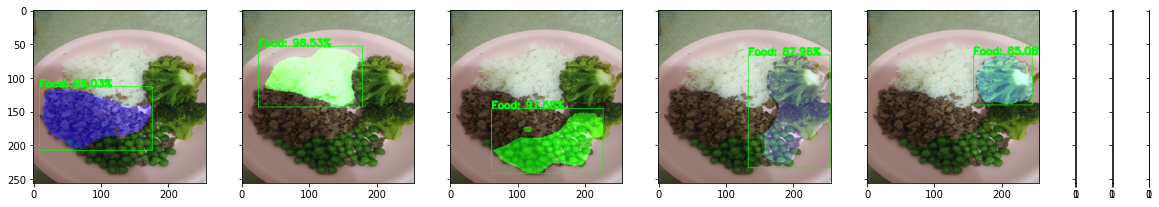

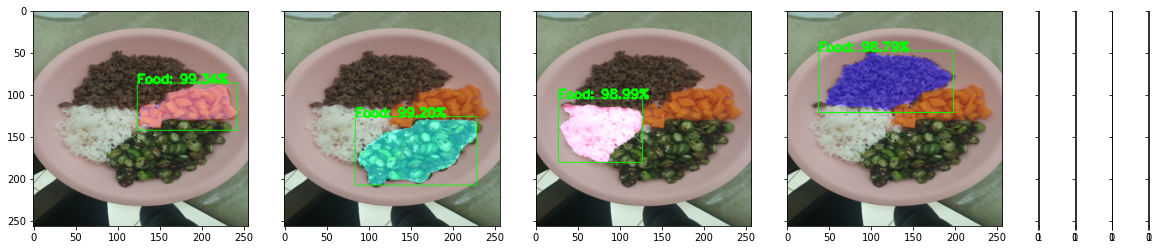

In [ ]:
filepaths = ["./mara1.png","./mara2.png", "joseila1.png","joseila2.png","joseila3.png", "joseila4.png"]

modelMaskrcnn.to(device)
modelMaskrcnn.eval()

for file in filepaths:
  instance_segmentation_api(file, codes, modelMaskrcnn, threshold=0.8)
  print("\n\n")

## Use torchvision engine to train

In [79]:
sys.path.append(path_to_drive + 'DevDiabetesLearning/DiabetesLearningAI/torchvisionReferences/detection') #make src files importable
from torchvisionReferences.detection.engine import train_one_epoch, evaluate

In [80]:
# modelFoodDetection = get_model_instance_segmentation(num_classes=2)
# modelFoodDetection.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/DevDiabetesLearning/DiabetesLearningAI/datasetTCC_v1/original/models/maskrcnn-torchvision-foodDetection(best).pt"))

modelMaskrcnn = get_model_instance_segmentation(num_classes=len(codes), pretrainedModel=None)
modelMaskrcnn.transform.min_size = (imageSize,)
modelMaskrcnn.transform.max_size = imageSize

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
modelMaskrcnn.to(device)

# load trained model
# modelMaskrcnn.load_state_dict(torch.load(path + "models/maskrcnn-torchvision.pt"))

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(256,), max_size=256, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inp

### Training with frozen backbone

In [81]:
# construct an optimizer

freezeBackboneLayer(modelMaskrcnn)
params = [p for p in modelMaskrcnn.parameters() if p.requires_grad]

lr = 0.001
wd = 0.0005
num_epochs = 5

optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=3,
#                                                 gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=num_epochs,
                                                 cycle_momentum=True)


In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(modelMaskrcnn, optimizer, trainDataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    results = evaluate(modelMaskrcnn, testDataloader, device=device)

torch.save(modelMaskrcnn.state_dict(), path + "models/temp-torchvision-aicrowd.pt")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [    0/13362]  eta: 11:05:24  lr: 0.000000  loss: 7.0233 (7.0233)  loss_classifier: 5.9449 (5.9449)  loss_box_reg: 0.2472 (0.2472)  loss_mask: 0.7932 (0.7932)  loss_objectness: 0.0259 (0.0259)  loss_rpn_box_reg: 0.0121 (0.0121)  time: 2.9879  data: 2.3394  max mem: 8625
Epoch: [0]  [   10/13362]  eta: 2:36:28  lr: 0.000000  loss: 7.0238 (7.1374)  loss_classifier: 5.9449 (5.9730)  loss_box_reg: 0.2254 (0.2459)  loss_mask: 0.7755 (0.7644)  loss_objectness: 0.0703 (0.1227)  loss_rpn_box_reg: 0.0090 (0.0314)  time: 0.7032  data: 0.2369  max mem: 8625
Epoch: [0]  [   20/13362]  eta: 2:12:27  lr: 0.000001  loss: 6.9961 (7.0489)  loss_classifier: 5.9098 (5.9395)  loss_box_reg: 0.2137 (0.2462)  loss_mask: 0.7542 (0.7578)  loss_objectness: 0.0406 (0.0849)  loss_rpn_box_reg: 0.0061 (0.0205)  time: 0.4760  data: 0.0351  max mem: 8625
Degenerated bounding box!!!!!!! Fixing error
Epoch: [0]  [   30/13362]  eta: 2:03:22  lr: 0.000001  loss: 6.9121 (6.9856)  loss_classifier: 5.8418 (5.899

### Fine tunning

In [ ]:
# construct an optimizer

unfreezeBackboneLayer(modelMaskrcnn)
params = [p for p in modelMaskrcnn.parameters() if p.requires_grad]

lr = lr/2
wd = 0.0005
num_epochs = 5

optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=wd)

# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                 step_size=3,
#                                                 gamma=0.1)

lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                 steps_per_epoch=len(trainDataloader), epochs=num_epochs,
                                                 cycle_momentum=True)


In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(modelMaskrcnn, optimizer, trainDataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    results = evaluate(modelMaskrcnn, testDataloader, device=device)

torch.save(modelMaskrcnn.state_dict(), path + "models/torchvision-aicrowd.pt")

In [ ]:
while True: pass

In [ ]:
wandb_logger.close()
wandb_logger.finalize("success")
wandb.finish()

### Error Analysis

In [ ]:
# evaluate using torchvision engine

evaluate(modelMaskrcnn, testDataloader, device=device)

creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Test:  [ 0/27]  eta: 0:01:42  model_time: 3.1824 (3.1824)  evaluator_time: 0.1561 (0.1561)  time: 3.7782  data: 0.4370  max mem: 2542
Test:  [26/27]  eta: 0:00:00  model_time: 0.7304 (0.8409)  evaluator_time: 0.0963 (0.1134)  time: 0.9057  data: 0.0209  max mem: 2542
Test: Total time: 0:00:26 (0.9961 s / it)
Averaged stats: model_time: 0.7304 (0.8409)  evaluator_time: 0.0963 (0.1134)
Accumulating evaluation results...
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.99s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.215
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.254
 Average Recal

In [ ]:
# use pytorch lightning model to calculate the other metrics

from pytorch_lightning import Trainer

tempModel = MaskRCNN(num_classes=len(codes), lr=lr, weight_decay=wd, epochs=epochs, freezeBackbone=True)
tempModel.modelMaskrcnn = modelMaskrcnn.to(device)
tempModel.predsThreshold = 0.5 # this controls miou and segmentation thresholds

testTrainer = Trainer(gpus=1)
testTrainer.test(model=tempModel, dataloaders=testDataloader)

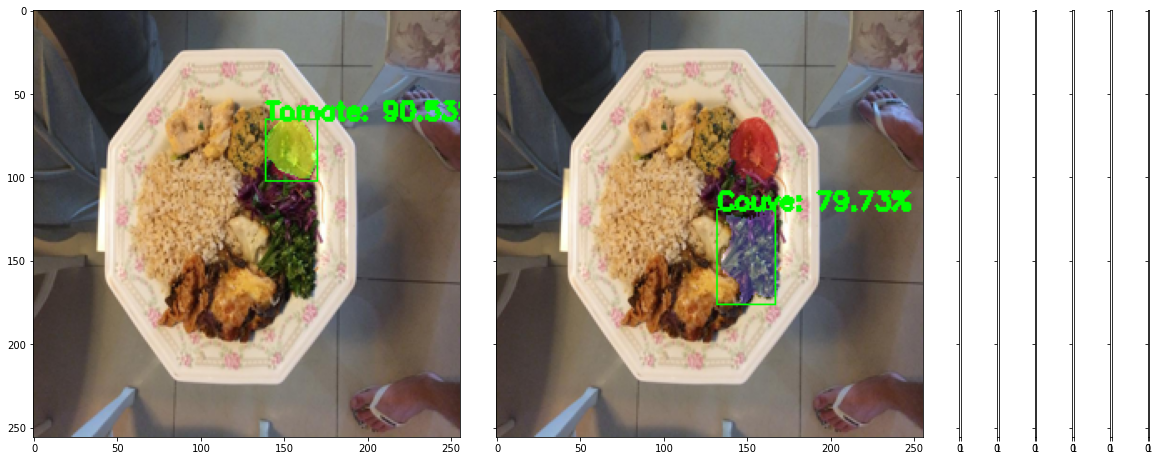

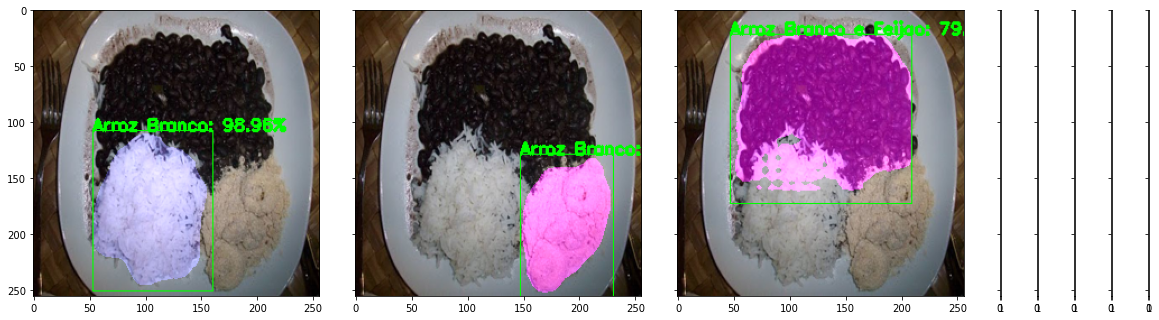

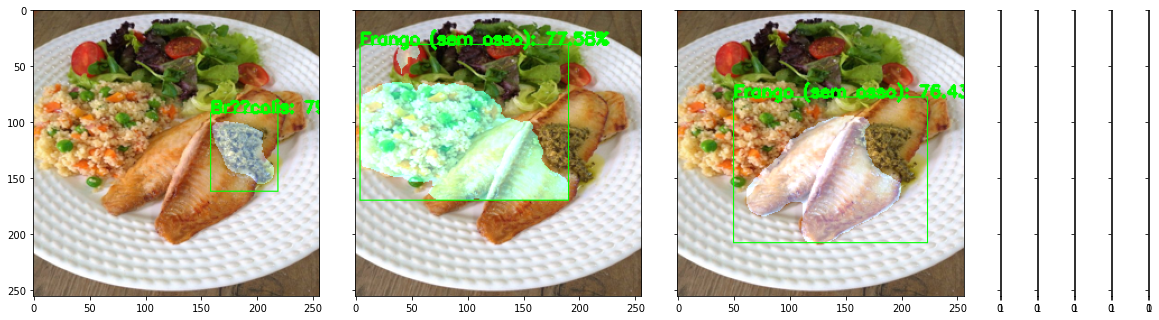

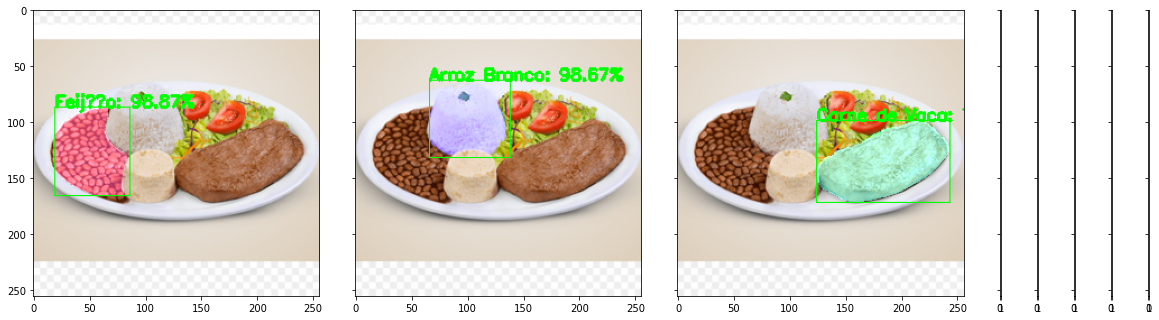

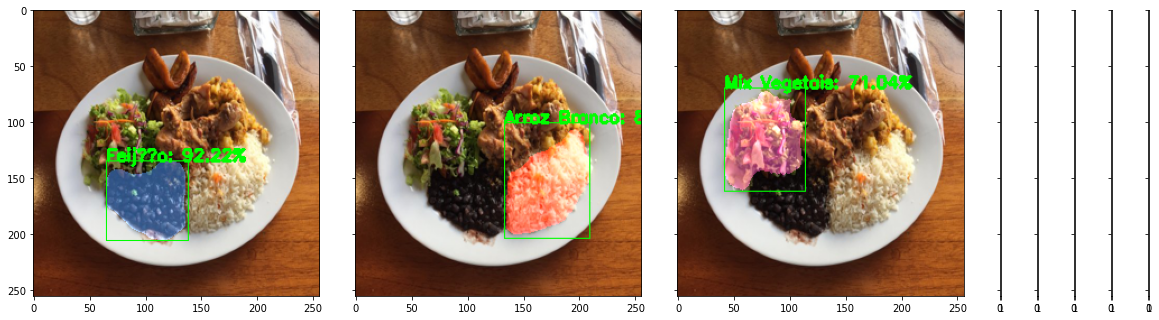

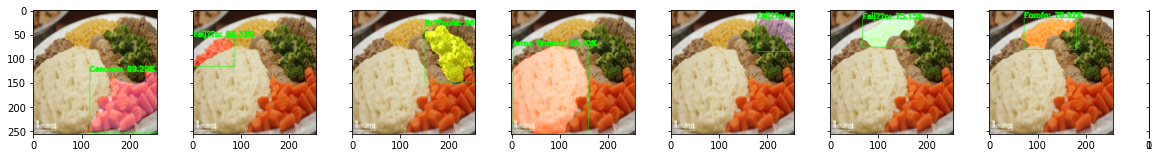

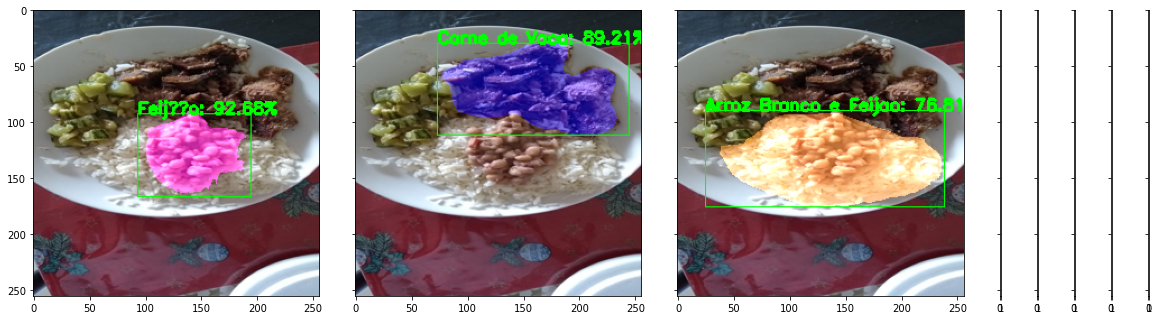

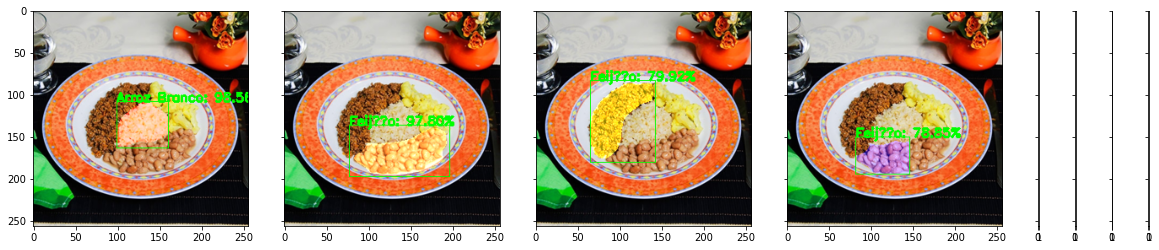

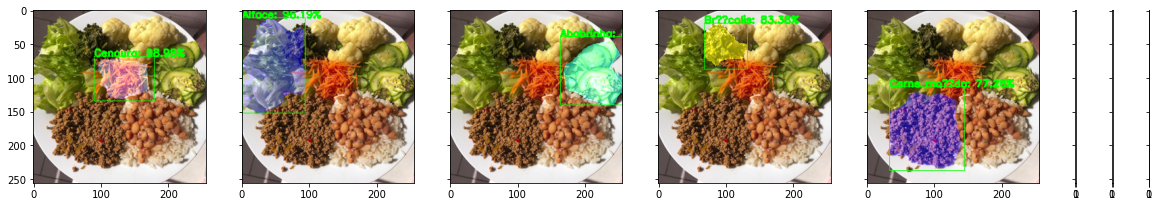

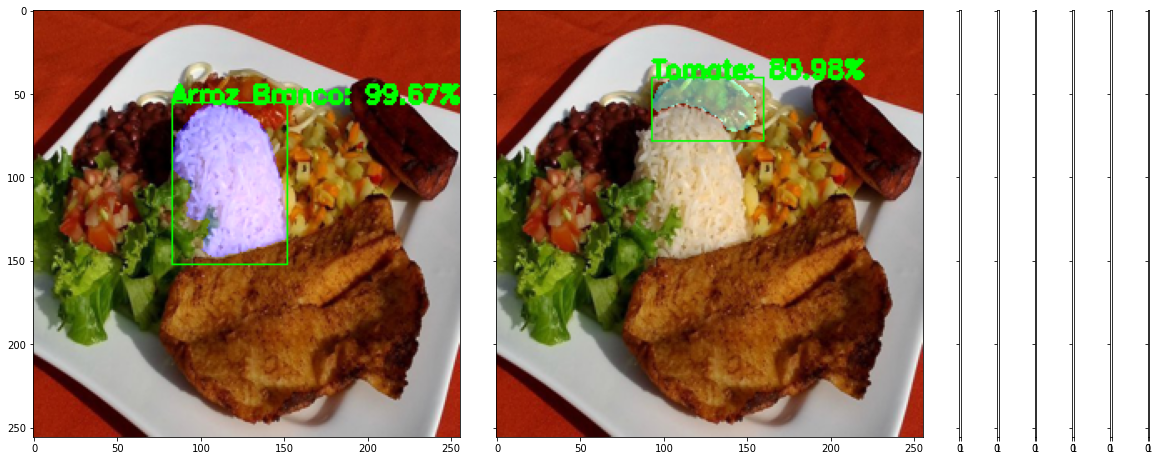

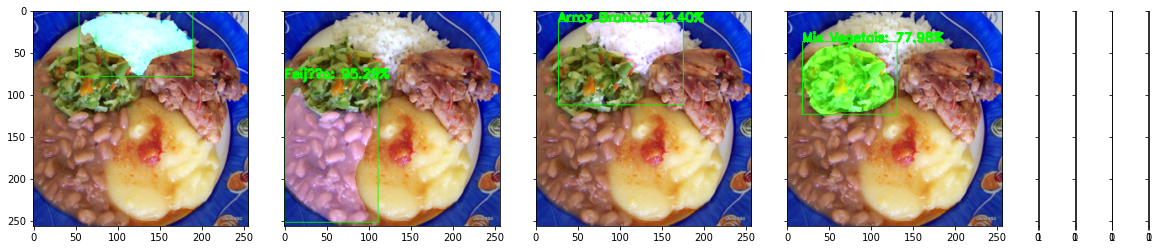

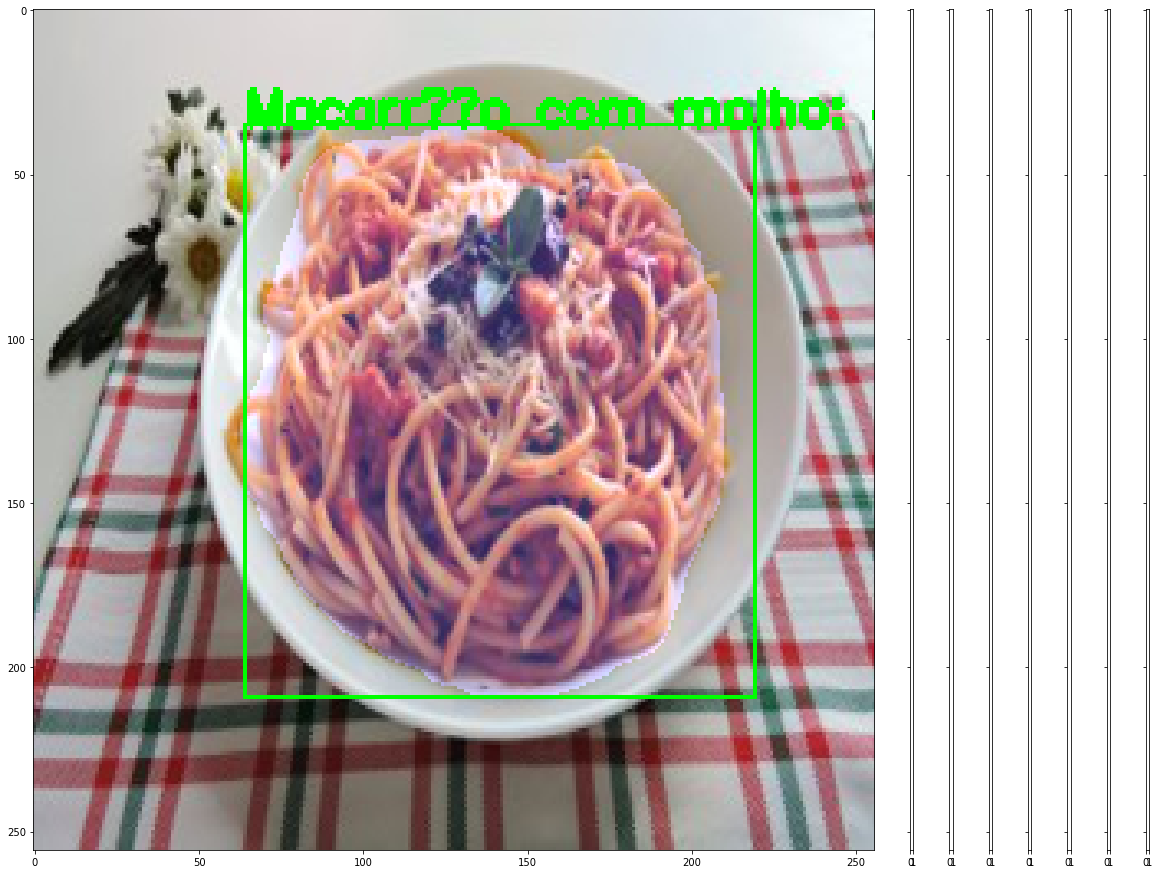

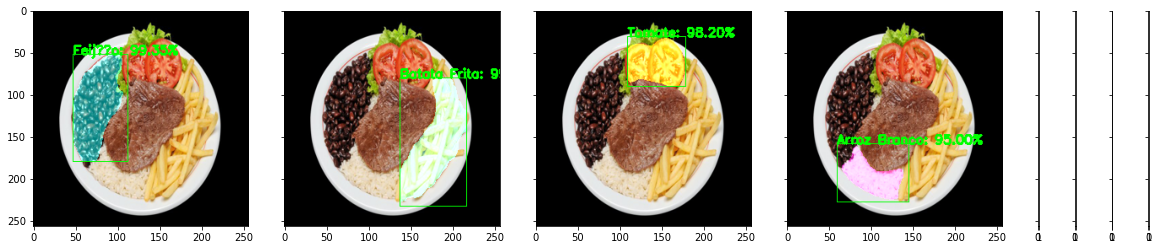

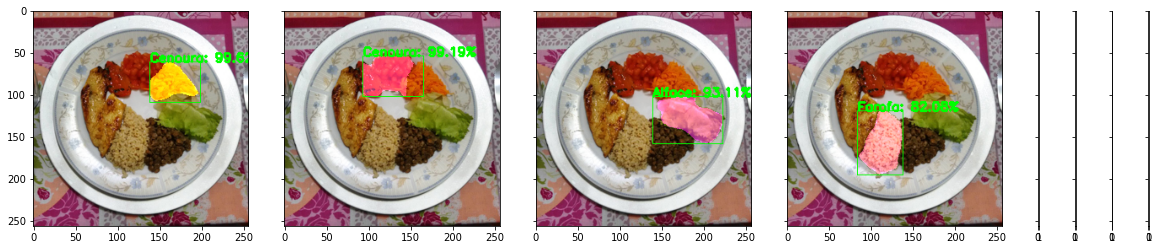

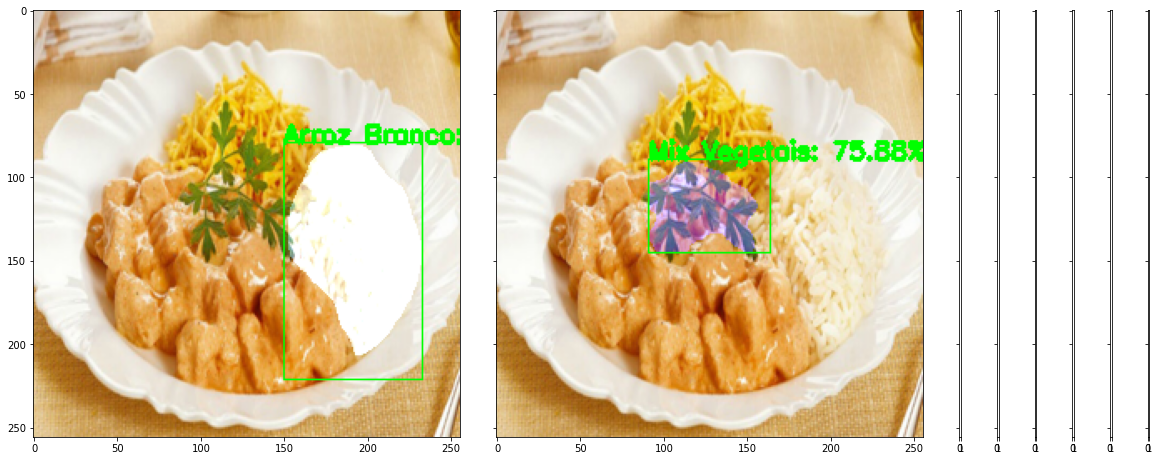

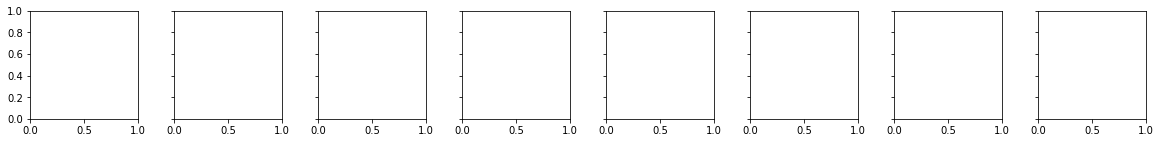

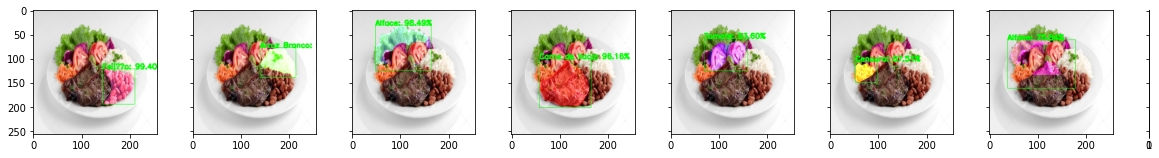

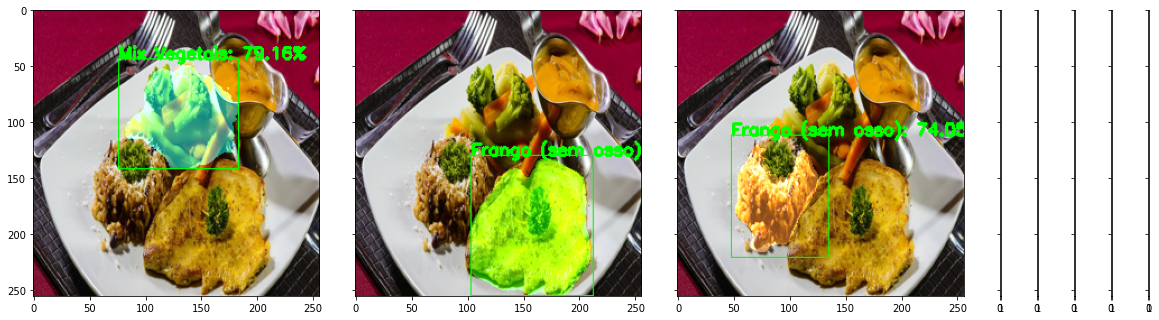

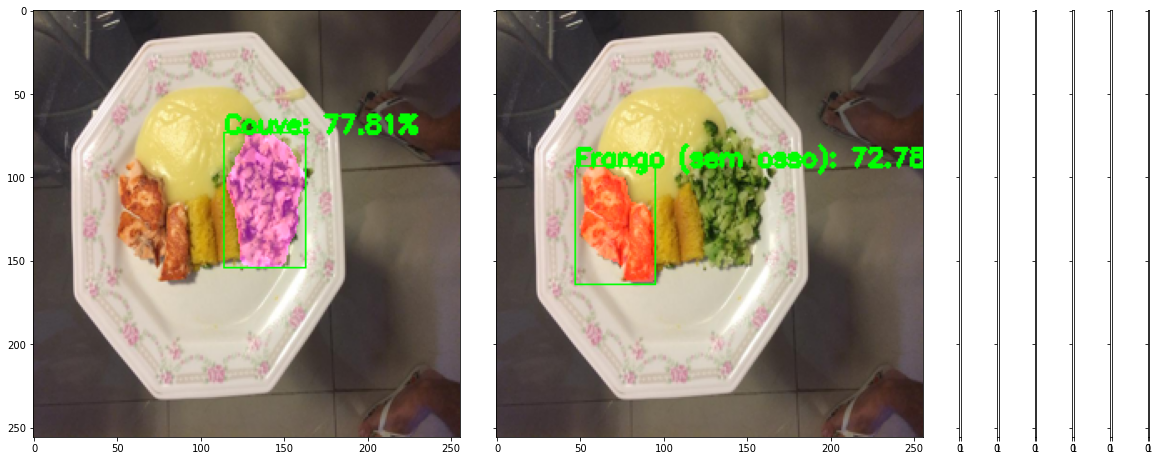

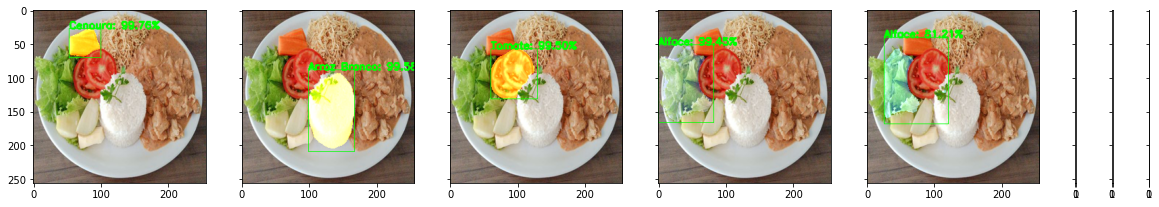

In [ ]:
# validate

start = 10
modelMaskrcnn.to(device)
modelMaskrcnn.eval()

for idx in range(start,start+20):
  instance_segmentation_api(str(X_test[idx]), codes, modelMaskrcnn, threshold=0.7)

### Predictions

In [ ]:
filepaths = ["./mara1.png","./mara2.png", "joseila1.png","joseila2.png","joseila3.png", "joseila4.png"]

modelMaskrcnn.to(device)
modelMaskrcnn.eval()

for file in filepaths:
  instance_segmentation_api(file, codes, modelMaskrcnn, threshold=0.8)
  print("\n\n")